In [22]:
# Core
import pandas as pd
import numpy as np
import pickle

# ML & Metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# MLflow
import mlflow
import mlflow.sklearn

In [23]:
# Load preprocessed dataset
df = pd.read_csv("../data/diabetes.csv")

# Define features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
# Train final model with best hyperparameters
final_model = LogisticRegression(C=0.3073767172930477, solver='liblinear', max_iter=1000, class_weight='balanced')
final_model.fit(X_train, y_train)

# Evaluate
y_prob = final_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.51      0.64        99
           1       0.49      0.87      0.63        55

    accuracy                           0.64       154
   macro avg       0.69      0.69      0.64       154
weighted avg       0.74      0.64      0.64       154



In [25]:
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the model
with open("../models/final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("✅ Final model saved as 'final_model.pkl'")


✅ Final model saved as 'final_model.pkl'


In [26]:
with mlflow.start_run(run_name="final_model"):
    mlflow.log_param("C", 0.3073767172930477)
    mlflow.log_param("solver", "liblinear")

    mlflow.sklearn.log_model(final_model, "model")
    print("✅ Final model logged to MLflow.")

2025/05/08 02:26:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final model logged to MLflow.
🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/0/runs/91dfa34455324457aa9184018ca0da71
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [27]:
with mlflow.start_run(run_name="final_model") as run:
    mlflow.log_param("C", 0.3073767172930477)
    mlflow.log_param("solver", "liblinear")
    
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    from sklearn.metrics import accuracy_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    mlflow.sklearn.log_model(final_model, "model")
    print("✅ Final model logged to MLflow.")

    # Model Registry 
    import time
    from mlflow.tracking import MlflowClient

    mlflow.set_tracking_uri("http://127.0.0.1:5000")

    run_id = run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    model_name = "DiabetesPredictionModel"

    client = MlflowClient()
    result = mlflow.register_model(model_uri=model_uri, name=model_name)

    time.sleep(5)
    print(f"✅ Registered model: {model_name} (version {result.version})")


2025/05/08 02:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DiabetesPredictionModel' already exists. Creating a new version of this model...
2025/05/08 02:26:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DiabetesPredictionModel, version 19


✅ Final model logged to MLflow.


Created version '19' of model 'DiabetesPredictionModel'.


✅ Registered model: DiabetesPredictionModel (version 19)
🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/0/runs/c930a9842a434f1bb6320d462e9a1722
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [28]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

model_name = "DiabetesPredictionModel"
version = 19

# Stage to Production
client.transition_model_version_stage(
    name=model_name,
    version=version,
    stage="Production",
    archive_existing_versions=True 
)

print(f"✅ Model '{model_name}' version {version} moved to Production stage.")


C:\Users\aysuk\AppData\Local\Temp\ipykernel_7872\1129449514.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


✅ Model 'DiabetesPredictionModel' version 19 moved to Production stage.


In [31]:
import requests
import json

url = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}

payload = {
    "inputs": [
        [6, 148, 72, 35, 0, 33.6, 0.627, 50]  
    ]
}

response = requests.post(url, headers=headers, data=json.dumps(payload))
print("✅ Prediction:", response.json())


✅ Prediction: {'predictions': [1]}


In [32]:
# Simulate performance monitoring over time
# At each step, sample a different subset of the test data
for step in range(5):
    # Randomly sample 50 test instances (without replacement)
    X_sample, y_sample = resample(X_test, y_test, n_samples=50, random_state=step)
    
    # Make predictions
    y_pred = final_model.predict(X_sample)
    
    # Calculate metrics
    acc = accuracy_score(y_sample, y_pred)
    f1 = f1_score(y_sample, y_pred)
    
    # Log the metrics to MLflow with a time step
    mlflow.log_metric("simulated_accuracy", acc, step=step)
    mlflow.log_metric("simulated_f1_score", f1, step=step)

print("✅ Simulated monitoring metrics have been logged to MLflow.")


✅ Simulated monitoring metrics have been logged to MLflow.


✅ Confusion matrix has been logged as an artifact to MLflow.


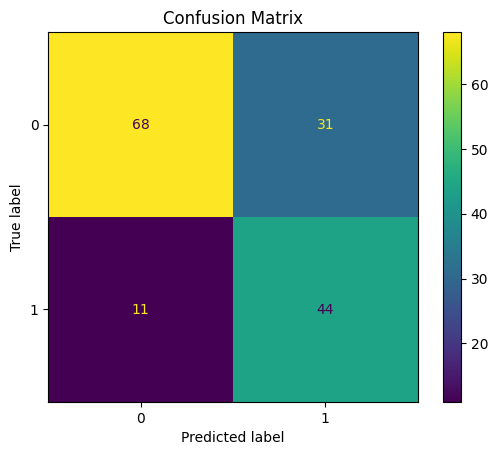

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions on the test set
y_pred = final_model.predict(X_test)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save as image

# Log the image as an artifact to MLflow
import mlflow
mlflow.log_artifact("confusion_matrix.png")

print("✅ Confusion matrix has been logged as an artifact to MLflow.")